In [1]:
%matplotlib inline


# Segmenting the picture of a raccoon face in regions


This example uses :ref:`spectral_clustering` on a graph created from
voxel-to-voxel difference on an image to break this image into multiple
partly-homogeneous regions.

This procedure (spectral clustering on an image) is an efficient
approximate solution for finding normalized graph cuts.

There are two options to assign labels:

* with 'kmeans' spectral clustering will cluster samples in the embedding space
  using a kmeans algorithm
* whereas 'discrete' will iteratively search for the closest partition
  space to the embedding space.


In [2]:
print(__doc__)

# Author: Gael Varoquaux <gael.varoquaux@normalesup.org>, Brian Cheung
# License: BSD 3 clause

import time

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

if sp_version < (0, 12):
    raise SkipTest("Skipping because SciPy version earlier than 0.12.0 and "
                   "thus does not include the scipy.misc.face() image.")


# load the raccoon face as a numpy array
try:
    face = sp.face(gray=True)
except AttributeError:
    # Newer versions of scipy have face in misc
    from scipy import misc
    face = misc.face(gray=True)

# Resize it to 10% of the original size to speed up the processing
face = sp.misc.imresize(face, 0.10) / 255.

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(face)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 25

Automatically created module for IPython interactive environment


Visualize the resulting regions


Spectral clustering: kmeans, 3.88s
Spectral clustering: discretize, 3.37s


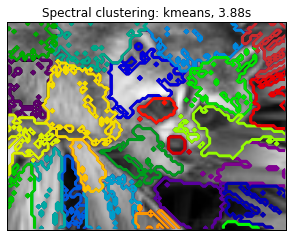

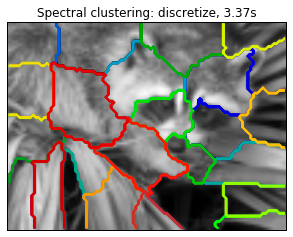

In [3]:
for assign_labels in ('kmeans', 'discretize'):
    t0 = time.time()
    labels = spectral_clustering(graph, n_clusters=N_REGIONS,
                                 assign_labels=assign_labels, random_state=1)
    t1 = time.time()
    labels = labels.reshape(face.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(face, cmap=plt.cm.gray)
    for l in range(N_REGIONS):
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.spectral(l / float(N_REGIONS))])
    plt.xticks(())
    plt.yticks(())
    title = 'Spectral clustering: %s, %.2fs' % (assign_labels, (t1 - t0))
    print(title)
    plt.title(title)
plt.show()